# Problem Statement
Global Mart is an online supergiant store that has worldwide operations. This store takes orders and delivers across the globe and deals with all the major product categories — consumer, corporate and home office.


As a sales manager for this store, you have to forecast the sales of the products for the next 6 months, so that you have a proper estimate and can plan your inventory and business processes accordingly.

-  find out the most consistently profitable market-segment and forecast the sales and demand for that single market-segment 

steps
- 1 .Reading and inspecting data
- 2. Data Preparation and EDA
- 3. Finding the most profitable market segment
- 4. Filtering the sales data of 'APAC_Consumer' into a dataframe 'data'
- 5. Time series analysis
- 6. Exponential smoothing methods
    - 6.1 Simple exponential smoothing
    - 6.2 Holt’s exponential smoothing
    - 6.3 Holt-Winters’ exponential smoothing - Additive
    - 6.4 Holt-Winters’ exponential smoothing - Multiplicative
- 7. ARIMA set of techniques
    - 7.1 AR model
    - 7.2 MA model
    - 7.3 ARMA model
    - 7.4 ARIMA model
    - 7.5 SARIMA model
- 8. Conclusions



In [1]:
#importing libraries
import numpy as np,pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#supressing warnings
import warnings
warnings.filterwarnings('ignore')

# 1 .Reading and inspecting data

In [3]:
# storing data to df
df = pd.read_csv('Global+Superstore+Data.csv')
df.head()

,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


In [4]:
#shape of df
df.shape

(51290, 5)

-  There are 51290 rows and 5 columns in the data set

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  51290 non-null  object 
 1   Segment     51290 non-null  object 
 2   Market      51290 non-null  object 
 3   Sales       51290 non-null  float64
 4   Profit      51290 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


- There are no null values in any of the columns

In [6]:
df.describe() #describing numerical columns

,Sales,Profit
count,51290.000000,51290.000000
mean,246.490581,28.610982
std,487.565361,174.340972
min,0.444000,-6599.978000
25%,30.758625,0.000000
50%,85.053000,9.240000
75%,251.053200,36.810000
max,22638.480000,8399.976000


# 2. Data Preparation and EDA

In [7]:
# combining the market and segement through string concatenation and storing them in a new column 'Market_Segment'
df['Market_Segment'] = df.Market+'_'+df.Segment

In [8]:
# Dropping 'Segment' and 'Market' columns from the dataframe
df.drop(['Segment','Market'],axis = 1,inplace = True)

In [9]:
# checking unique values in each columns
df.nunique()

Order Date         1430
Sales             22995
Profit            24575
Market_Segment       21
dtype: int64

- There are 21 unique Market segments
- Since the count of unique order dates are less than the total number of rows,
   we could say there were multiple orders on same days.

In [10]:
#  21 unique Market segments are
df.Market_Segment.unique()

array(['US_Consumer', 'APAC_Corporate', 'APAC_Consumer', 'EU_Home Office',
       'Africa_Consumer', 'US_Corporate', 'EMEA_Consumer',
       'LATAM_Home Office', 'EU_Corporate', 'EMEA_Corporate',
       'LATAM_Consumer', 'EU_Consumer', 'US_Home Office',
       'LATAM_Corporate', 'Africa_Corporate', 'APAC_Home Office',
       'EMEA_Home Office', 'Africa_Home Office', 'Canada_Corporate',
       'Canada_Home Office', 'Canada_Consumer'], dtype=object)

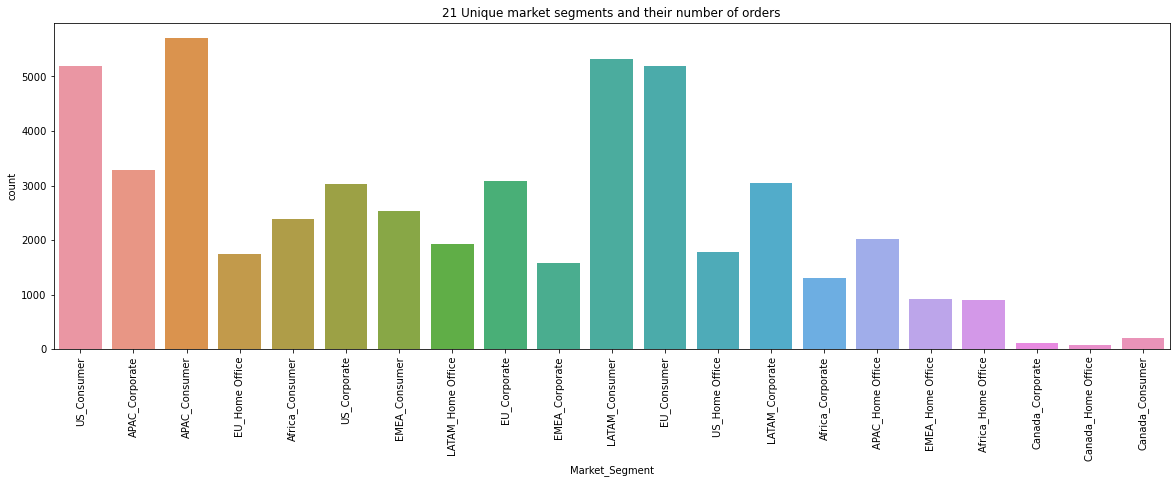

In [11]:
# count plot of 21 unique Market segments
plt.figure(figsize = [20,6])
sns.countplot(df.Market_Segment)
plt.xticks(rotation=90)
plt.title('21 Unique market segments and their number of orders')
plt.show()

 - APAC_Consumer market segment has the most number of orders

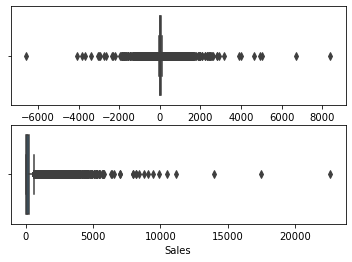

In [12]:
# plotting boxplots of sales profits and sales
plt.subplot(2,1,1)
sns.boxplot(df.Profit,whis=1.5)

plt.subplot(2,1,2)
sns.boxplot(df.Sales,whis=1.5)

plt.show()

- There are outliers in both sales and profits
- But these may not be false data, beacuse in market it is possible to have extreme values as profit and sales.
- Infact these extreme data points can't be removed as they should be considered while identifying the market segment with  least coefficient of variations( most profitable segment).

In [13]:
# setting 'Market_Segment' as index
df.set_index('Market_Segment',inplace = True)

In [14]:
# Converting the order-date into a date-time format (year-month format)
df['Order Date'] =pd.to_datetime(df['Order Date']).dt.to_period('m')
df.head()

,Order Date,Sales,Profit
Market_Segment,,,
US_Consumer,2012-07,2309.650,762.1845
APAC_Corporate,2013-05,3709.395,-288.7650
APAC_Consumer,2013-10,5175.171,919.9710
EU_Home Office,2013-01,2892.510,-96.5400
Africa_Consumer,2013-05,2832.960,311.5200


In [15]:
#checking the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51290 entries, US_Consumer to LATAM_Consumer
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   Order Date  51290 non-null  period[M]
 1   Sales       51290 non-null  float64  
 2   Profit      51290 non-null  float64  
dtypes: float64(2), period[M](1)
memory usage: 1.6+ MB


In [16]:
df['Order Date'].describe()   

count       51290
unique         48
top       2014-11
freq         1993
Name: Order Date, dtype: object

- There are 48 unique month-year combinations

In [17]:
# monthly aggregated profit data across market_segments (as df_profit)
df_profit = df.pivot_table(index = 'Order Date',columns = 'Market_Segment',values='Profit',aggfunc = 'sum')

In [18]:
df_profit.head()

Market_Segment,APAC_Consumer,APAC_Corporate,APAC_Home Office,Africa_Consumer,Africa_Corporate,Africa_Home Office,Canada_Consumer,Canada_Corporate,Canada_Home Office,EMEA_Consumer,...,EMEA_Home Office,EU_Consumer,EU_Corporate,EU_Home Office,LATAM_Consumer,LATAM_Corporate,LATAM_Home Office,US_Consumer,US_Corporate,US_Home Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2011-01,2254.4898,-173.7264,230.2656,265.539,520.026,391.515,447.33,12.57,NaN,-2952.594,...,392.526,2259.8670,841.3875,2534.568,540.44312,1021.05924,-26.59744,2465.8368,643.3689,1233.9329
2011-02,4627.8531,3600.7776,617.5407,-201.888,-31.689,825.606,26.43,9.24,87.99,464.160,...,368.070,-783.9945,2234.4060,162.255,1227.86616,814.03020,-356.80440,1853.5541,421.9256,553.9467
2011-03,2337.8319,3634.9365,205.1052,919.074,244.437,83.430,82.47,NaN,84.03,706.380,...,-15.570,1273.7100,2206.5960,269.745,2427.39612,178.66400,769.88400,204.2007,127.4696,-268.9314
2011-04,633.6423,90.7521,603.8478,381.315,941.751,417.618,55.08,6.51,NaN,121.353,...,-456.510,2980.0065,981.1470,130.371,1368.82948,872.64068,-554.22952,1434.8636,494.7315,2723.4358
2011-05,3838.9500,1028.4489,102.0315,-39.981,490.650,39.180,0.87,NaN,NaN,172.554,...,-33.591,673.0080,1719.0600,443.310,1749.39200,134.87252,-397.95600,833.9433,2912.7976,145.7781


#### train-test split 

In [19]:
# splitting the aggregated transaction data into train and test sets (42 months in train and 6 in test)
train = df_profit[:42]
test = df_profit[42:]
train.shape,test.shape

((42, 21), (6, 21))

In [20]:
train.head()

Market_Segment,APAC_Consumer,APAC_Corporate,APAC_Home Office,Africa_Consumer,Africa_Corporate,Africa_Home Office,Canada_Consumer,Canada_Corporate,Canada_Home Office,EMEA_Consumer,...,EMEA_Home Office,EU_Consumer,EU_Corporate,EU_Home Office,LATAM_Consumer,LATAM_Corporate,LATAM_Home Office,US_Consumer,US_Corporate,US_Home Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2011-01,2254.4898,-173.7264,230.2656,265.539,520.026,391.515,447.33,12.57,NaN,-2952.594,...,392.526,2259.8670,841.3875,2534.568,540.44312,1021.05924,-26.59744,2465.8368,643.3689,1233.9329
2011-02,4627.8531,3600.7776,617.5407,-201.888,-31.689,825.606,26.43,9.24,87.99,464.160,...,368.070,-783.9945,2234.4060,162.255,1227.86616,814.03020,-356.80440,1853.5541,421.9256,553.9467
2011-03,2337.8319,3634.9365,205.1052,919.074,244.437,83.430,82.47,NaN,84.03,706.380,...,-15.570,1273.7100,2206.5960,269.745,2427.39612,178.66400,769.88400,204.2007,127.4696,-268.9314
2011-04,633.6423,90.7521,603.8478,381.315,941.751,417.618,55.08,6.51,NaN,121.353,...,-456.510,2980.0065,981.1470,130.371,1368.82948,872.64068,-554.22952,1434.8636,494.7315,2723.4358
2011-05,3838.9500,1028.4489,102.0315,-39.981,490.650,39.180,0.87,NaN,NaN,172.554,...,-33.591,673.0080,1719.0600,443.310,1749.39200,134.87252,-397.95600,833.9433,2912.7976,145.7781


# 3. Finding the most profitable market segment 

In [21]:
#storing the mean and standard deviation of monthly aggregated profit in each market_segment in 'mean' and 'std' respectively
mean = np.mean(train)
std = np.std(train)

- We can compare the aggregated profits from different market segments using coefficient of variation which will normalise the standard deviation with the mean and gives a comparative figure on the basis of which we can identify the most profitable market segment.

In [22]:
#creating a datafram with ' mean' and 'std'
# calculating coefficient of variation (CoV)
# sorting the rows based on CoV
s = pd.DataFrame(mean)
s['std'] = std
s['CoV'] = std/mean
s.reset_index(inplace = True)
s.columns = ['Market_Segment','mean','std','CoV']
s.sort_values('CoV')

,Market_Segment,mean,std,CoV
0,APAC_Consumer,4400.894243,2300.457687,0.522725
1,APAC_Corporate,2574.919807,1364.837734,0.530051
12,EU_Consumer,3699.977143,2202.282289,0.595215
15,LATAM_Consumer,2295.555697,1569.632686,0.683770
13,EU_Corporate,2216.299429,1600.336696,0.722076
16,LATAM_Corporate,1122.633016,990.360880,0.882177
14,EU_Home Office,1224.456536,1148.627937,0.938072
2,APAC_Home Office,1511.088314,1523.508658,1.008219
18,US_Consumer,2686.740912,2715.031412,1.010530
19,US_Corporate,1754.199083,1880.200775,1.071829


 - The most profitable market segment should have the least value of CoV
 - from the above data it is clear that 'APAC_Consumer' has the least CoV value(0.522725) among all the    market_segments.
 - So the most profitable market segment would be 'APAC_Consumer' because it has least CoV, so it is more reliable (less variation).
 - So in the next session, we could forecast the sales data of 'APAC_Consumer'

# 4. Filtering the sales data of 'APAC_Consumer' into a dataframe 'data'

In [23]:
#### converting 'Order Date' from datetime format to timestamp

In [24]:
# checking datatype of 'Order Date' 
df['Order Date'].dtype

period[M]

In [25]:
# converting 'Order Date' from datetime format to timestamp
df['Order Date']=df['Order Date'].astype('str')
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [26]:
# checking datatype of 'Order Date' again
df['Order Date'].dtype

dtype('<M8[ns]')

In [27]:
# resetting the index
df.reset_index(inplace = True)

In [28]:
# selecting only those entries which belongs to 'APAC_Consumer' market_segment for further analysis
# storing them in df
df = df[df['Market_Segment'] == 'APAC_Consumer']

In [29]:
df.head()

,Market_Segment,Order Date,Sales,Profit
2,APAC_Consumer,2013-10-01,5175.171,919.971
6,APAC_Consumer,2011-07-01,1822.080,564.840
7,APAC_Consumer,2012-04-01,5244.840,996.480
14,APAC_Consumer,2013-06-01,3701.520,1036.080
29,APAC_Consumer,2012-02-01,1878.720,582.360


In [30]:
# dropping 'Market_Segment' and 'Profit' columns from df
df.drop(['Market_Segment','Profit'],axis = 1,inplace = True)

In [31]:
# creating a new dataframe containg order date and corresponding aggregated sales values for 'APAC_Consumer'
data = pd.DataFrame(df.groupby('Order Date')['Sales'].sum())
data.head()

,Sales
Order Date,
2011-01-01,18821.9898
2011-02-01,23313.3531
2011-03-01,26518.4919
2011-04-01,12046.0923
2011-05-01,25941.9000


In [32]:
data.shape

(48, 1)

# 5. Time series analysis

No handles with labels found to put in legend.


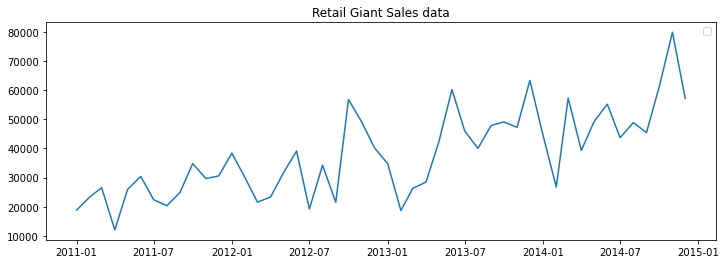

In [33]:
# plotting the sales data for 'APAC_Consumer'
plt.figure(figsize = [12,4])
plt.plot(data)
plt.title('Retail Giant Sales data')
plt.legend(loc= 'best')
plt.show()

In [34]:
# checking for missing values
data.isnull().sum()

Sales    0
dtype: int64

-  there are no missing values  in the sales data of 'APAC_Consumer'

<AxesSubplot:xlabel='Sales'>

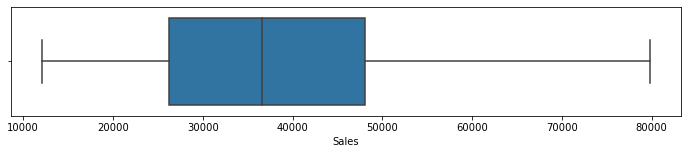

In [35]:
# checking for outliers
plt.figure(figsize = [12,2])
sns.boxplot(data.Sales,whis=1.5)

- Even though there were outliers in the entire sales data, within 'APAC_Consumer' data there are no outliers.

In [36]:
# Splitting the time series data into train and test sets

In [37]:
train = data[:42]
test = data[42:]
train.shape,test.shape

((42, 1), (6, 1))

#### Decomposing the time series data

- time series can be split into its various components that is the Trend, Seasonality, and residuals


In [38]:
#Additive

- 

The individual components can be added to get the time-series data


In [39]:
from pylab import rcParams
import statsmodels.api as sm

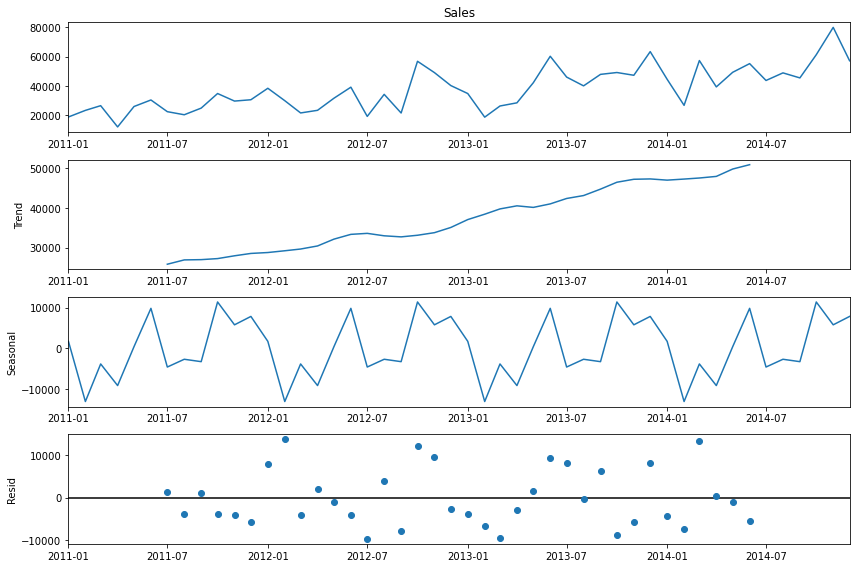

In [40]:
rcParams['figure.figsize'] = [12,8]
decomposition = sm.tsa.seasonal_decompose(data.Sales,model = 'additive')
decomposition.plot()
plt.show()

In [41]:
### Multiplicative seasonal decomposition


- The individual components can be multiplied to get the time-series data

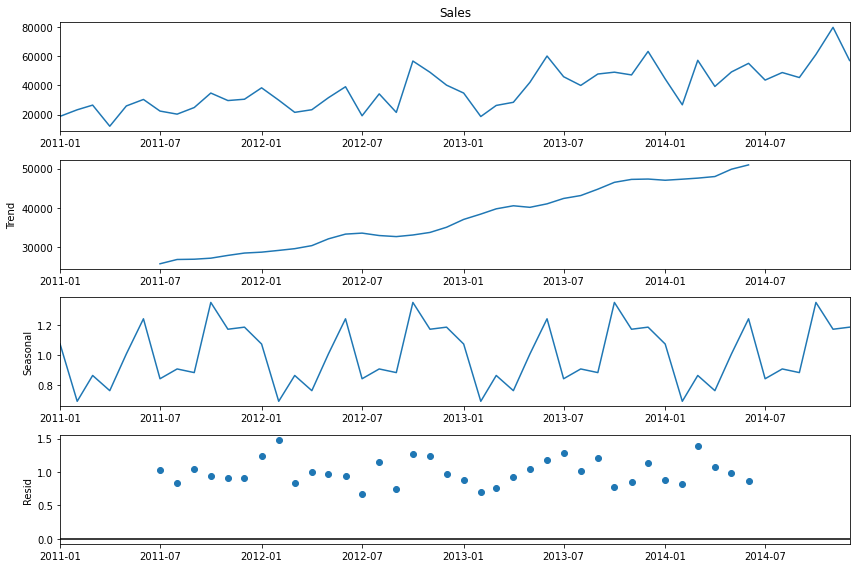

In [42]:
decomposition = sm.tsa.seasonal_decompose(data.Sales,model = 'multiplicative')
decomposition.plot()
plt.show()

- Our time series has more than 10 historical data points
- There is a upward trend
- There is a seasonal component
So from the flow chart of time series models, it is expected that `Holt Winters' smoothing method and SARIMA model` can better forecast  the monthly sales

#  6. Exponential smoothing methods

####     6.1.Simple exponential smoothing

In [43]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

- In this smoothing technique, the forecast observation data, is a function of the level component

In [44]:
#model building using train set
model = SimpleExpSmoothing(train.Sales)
model_fit = model.fit(optimized=True)
model_fit.params

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


{'smoothing_level': 0.24674418604651163,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 18821.9898,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [45]:
# forecasting the sales for next 6 months
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(6)

In [46]:
### Plot train, test and forecast

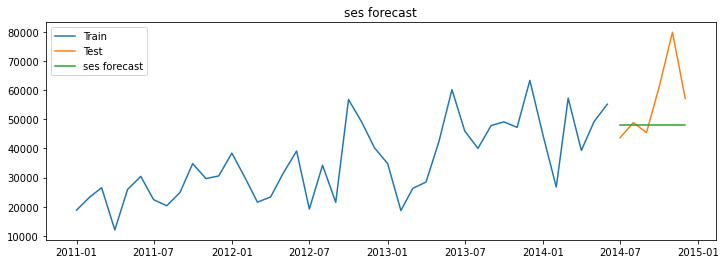

In [47]:
plt.figure(figsize = [12,4])
plt.plot(train,label = 'Train')
plt.plot(test,label = 'Test')
plt.plot(y_hat_ses.ses_forecast,label='ses forecast')
plt.legend(loc = 'best')
plt.title('ses forecast')
plt.show()

 - Simple exponential model is able to capture only the level of time series data

In [48]:
### Calculating RMSE and MAPE

In [49]:
from sklearn.metrics import mean_squared_error

In [50]:
rmse = np.sqrt(mean_squared_error(test.Sales,y_hat_ses.ses_forecast)).round(2)
mape = np.round(np.mean(np.abs(test.Sales-y_hat_ses.ses_forecast)/test.Sales)*100,2)

In [51]:
# creating a dataframe to store rmse an mape values
smoothing_results = pd.DataFrame({'Method':['Simple exponential smoothing'],'RMSE':[rmse],
                               'MAPE':[mape] })

smoothing_results

,Method,RMSE,MAPE
0,Simple exponential smoothing,14627.34,15.74


#### 6.2 Holt’s exponential smoothing

In [52]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [53]:
#model building using train set
model = ExponentialSmoothing(np.asarray(train.Sales),seasonal_periods = 12,
                          trend = 'additive',seasonal = None)
model_fit = model.fit(smoothing_level=0.2,smoothing_slope = 0.01,optimized  = False)
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_trend': 0.01,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 18821.9898,
 'initial_trend': 4491.363300000001,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [54]:
#forecasting the sales for next 6 months using the model
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(6)

In [55]:
### Plotting train, test and forecast

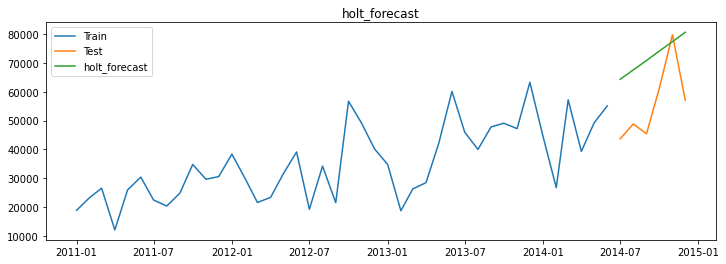

In [56]:
plt.figure(figsize = [12,4])
plt.plot(train,label = 'Train')
plt.plot(test,label = 'Test')
plt.plot(y_hat_holt.holt_forecast,label='holt_forecast')
plt.legend(loc='best')
plt.title('holt_forecast')
plt.show()

 - Holt's method captures both level and slope

In [57]:
### Calculating RMSE and MAPE

In [58]:
rmse = np.sqrt(mean_squared_error(test.Sales,y_hat_holt.holt_forecast)).round(2)
mape = np.round(np.mean(np.abs(test.Sales-y_hat_holt.holt_forecast)/test.Sales)*100,2)

In [59]:
#adding the reslt to previously created dataframe s
s= pd.DataFrame({'Method':['Holt\'s exponential smoothing'],'RMSE':[rmse],
                               'MAPE':[mape] })

smoothing_results = pd.concat([smoothing_results,s])
smoothing_results

,Method,RMSE,MAPE
0,Simple exponential smoothing,14627.34,15.74
0,Holt's exponential smoothing,18976.37,34.57


#### 6.3 Holt-Winters’ exponential smoothing - Additive



- Forecasts based on level, trend and seasonality of a time series


In [60]:
#model building
model = ExponentialSmoothing(np.asarray(train.Sales),seasonal_periods=12,
                            trend= 'add',seasonal='add')
model_fit = model.fit(optimized=True)
model_fit.params

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


{'smoothing_level': 0.07571428571428572,
 'smoothing_trend': 0.010816326530612248,
 'smoothing_seasonal': 0.1026984126984127,
 'damping_trend': nan,
 'initial_level': 34110.965325000005,
 'initial_trend': 730.4167145833334,
 'initial_seasons': array([-15288.975525, -10797.612225,  -7592.473425, -22064.873025,
         -8169.065325,  -3712.033725, -11679.370425, -13779.891825,
         -9250.570425,    676.322775,  -4462.610625,  -3556.103925]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [61]:
# forecasting sales for next 6 months
y_hat_hwa = test.copy()
y_hat_hwa['hwa_forecast'] = model_fit.forecast(6)

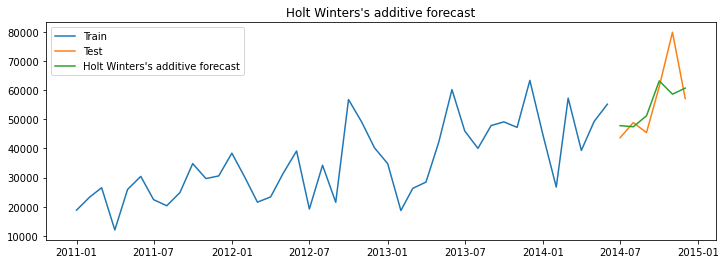

In [62]:
#### Plotting train, test and forecast
plt.figure(figsize = [12,4])
plt.plot(train,label = 'Train')
plt.plot(test,label = 'Test')
plt.plot(y_hat_hwa.hwa_forecast,label='Holt Winters\'s additive forecast')
plt.legend(loc = 'best')
plt.title('Holt Winters\'s additive forecast')
plt.show()

 - Holt Winters's additive forecastable to capture seasonal variation, trend and level

In [63]:
### Calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test.Sales,y_hat_hwa.hwa_forecast)).round(2)
mape = np.round(np.mean(np.abs(test.Sales-y_hat_hwa.hwa_forecast)/test.Sales)*100,2)

In [64]:
s= pd.DataFrame({'Method':['Holt Winters\'s additive forecast'],'RMSE':[rmse],
                               'MAPE':[mape] })

smoothing_results = pd.concat([smoothing_results,s])
smoothing_results

,Method,RMSE,MAPE
0,Simple exponential smoothing,14627.34,15.74
0,Holt's exponential smoothing,18976.37,34.57
0,Holt Winters's additive forecast,9306.82,10.17


#### 6.4 Holt-Winters’ exponential smoothing - Multiplicative

In [65]:
#model building using train set
model = ExponentialSmoothing(np.asarray(train.Sales),seasonal_periods=12,
                            trend = 'add',seasonal='multiplicative')
model_fit = model.fit(optimized=True)
print(model_fit.params)

{'smoothing_level': 0.040357142857142855, 'smoothing_trend': 0.0001, 'smoothing_seasonal': 0.13709183673469388, 'damping_trend': nan, 'initial_level': 34110.965325000005, 'initial_trend': 730.4167145833334, 'initial_seasons': array([0.55178708, 0.68345627, 0.77741839, 0.35314428, 0.76051498,
       0.8911777 , 0.65760657, 0.5960275 , 0.72880948, 1.01982714,
       0.86917372, 0.89574895]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [66]:
# forecasting sales for next 6 months using the model
y_hat_hwm = test.copy()
y_hat_hwm['hwm_forecast'] = model_fit.forecast(6)

In [67]:
#### Plotting train, test and forecast

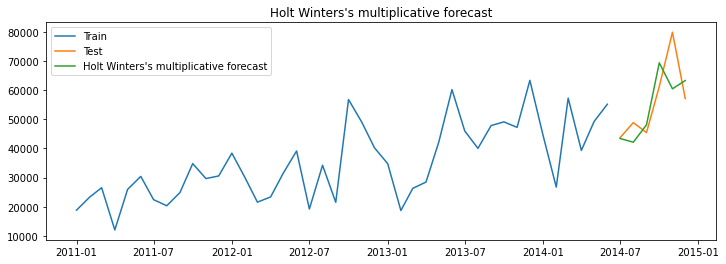

In [68]:
plt.figure(figsize = [12,4])
plt.plot(train,label = 'Train')
plt.plot(test,label = 'Test')
plt.plot(y_hat_hwm.hwm_forecast,label= 'Holt Winters\'s multiplicative forecast')
plt.legend(loc = 'best')
plt.title('Holt Winters\'s multiplicative forecast')
plt.show()

In [69]:
### Calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test.Sales,y_hat_hwm.hwm_forecast)).round(2)
mape = np.round(np.mean(np.abs(test.Sales-y_hat_hwm.hwm_forecast)/test.Sales)*100,2)

In [70]:
# adding results to s
s= pd.DataFrame({'Method':['Holt Winters\' multiplicative method'],'RMSE':[rmse],
                               'MAPE':[mape] })

smoothing_results = pd.concat([smoothing_results,s])
smoothing_results

,Method,RMSE,MAPE
0,Simple exponential smoothing,14627.34,15.74
0,Holt's exponential smoothing,18976.37,34.57
0,Holt Winters's additive forecast,9306.82,10.17
0,Holt Winters' multiplicative method,9423.23,11.43


 - Among the various smoothing techniques performed Holt Winters's additive forecast has the least mape and rmse values
 -  	Holt Winters' additive forecast is the best technique for forecasting the sales for next 6 months.

# 7. ARIMA set of techniques

In the AR set of methods, we will be still using the past values of the time-series, but we are also considering the correlation of those past values with the actual/current values. 

There are two fundamental assumptions to build an autoregressive model. They are —

- Stationarity
- Autocorrelation

#### Stationary vs Non stationary time series

- for a statioanary time series the statistical properties remain constant over time. There will be no trend, seasonality and cyclicity in the series.

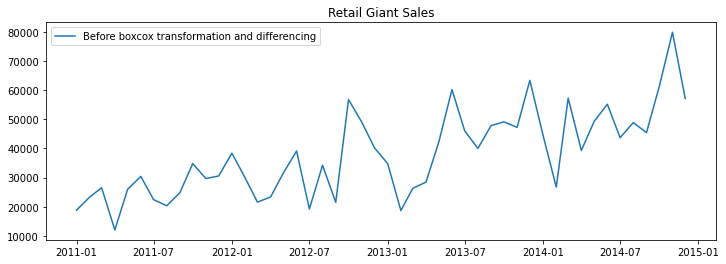

In [71]:
#plotting the time series data
plt.figure(figsize = [12,4])
plt.plot(data.Sales,label ='Before boxcox transformation and differencing')
plt.legend(loc = 'best')
plt.title('Retail Giant Sales')
plt.show()

- our data clearly shows an upward trend over time
- so this couls be non stationary data , let's further confirm using adf and kpss tests.

##### Augmented Dickey-Fuller (ADF) test¶

In [72]:
from statsmodels.tsa.stattools import adfuller

In [73]:
#adf test for checking stationarity
adf_test = adfuller(data)
print('ADF Statistic: %f'%adf_test[0],
      'Critical values at 0.05: %.2f'%adf_test[4]['5%'],
      'P-value: %f'%adf_test[1])

ADF Statistic: -3.376024 Critical values at 0.05: -2.93 P-value: 0.011804


- Null hypothesis of ADF test is that the time series is non-stationary data
- here p value is less than 0.05 so we can reject this null hypothesis

##### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [74]:
from statsmodels.tsa.stattools import kpss

In [75]:
kpss_test = kpss(data)
print('KPSS Statistic : %f'%kpss_test[0],
     'Critical value at 0.05: %.2f'%kpss_test[3]['5%'],
     'P- value:%f'%kpss_test[1])

KPSS Statistic : 0.577076 Critical value at 0.05: 0.46 P- value:0.024720


-  Null hypothesis of KPSS test is that the time series is  stationary data
-  here p value is less than 0.05 so we  reject this null hypothesis.
- this is a non-stationary time series data




- so let's first convert it into a stationary set
- The two tools for converting a non-stationary series into stationary series are:

    
    Transformation
    Differencing


### Box cox transformation to make variance constant

In [76]:
from scipy.stats import boxcox

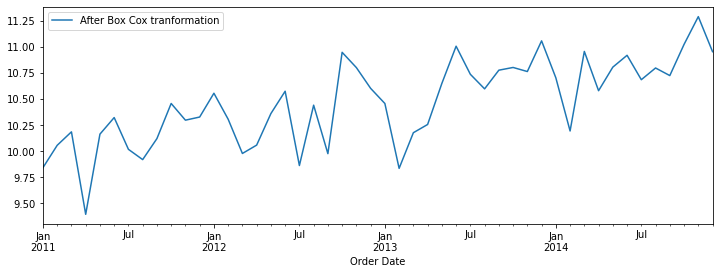

In [77]:
data_boxcox = pd.Series(boxcox(data.Sales,lmbda=0),index = data.index)

data_boxcox.plot(figsize = [12,4],label='After Box Cox tranformation')
plt.legend(loc = 'best')

### Differencing to remove trend

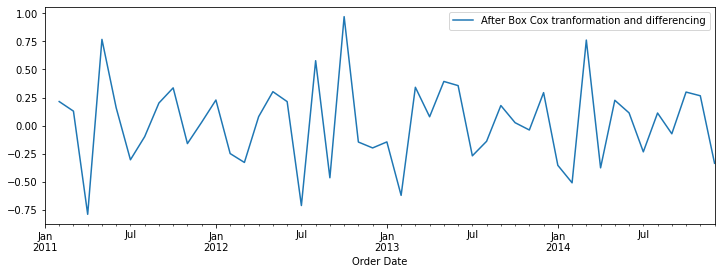

In [78]:
data_boxcox_diff = pd.Series(data_boxcox-data_boxcox.shift(),data.index)

data_boxcox_diff.plot(figsize = [12,4],label =  'After Box Cox tranformation and differencing')
plt.legend(loc = 'best')

- looks like a stationary series
- The fluctuations are under constant limits
- mean is centered around zero

In [79]:
# data after boxcox transformation and differencing
data_boxcox_diff.head()

Order Date
2011-01-01         NaN
2011-02-01    0.214000
2011-03-01    0.128816
2011-04-01   -0.789102
2011-05-01    0.767119
dtype: float64

In [80]:
# after differencing one row has null value, let's remove that row.
data_boxcox_diff.dropna(inplace = True)

- Now that we have performed boxcox transformation and differencing, let's check if the data has actually converted to a stationary set, using adf and kpss tests.

### Augmented Dickey-Fuller (ADF) test¶

In [81]:
adf_test = adfuller(data_boxcox_diff)
print('ADF Statistic: %f'%adf_test[0],
      'Critical values at 0.05: %.2f'%adf_test[4]['5%'],
      'P-value: %f'%adf_test[1])

ADF Statistic: -4.535011 Critical values at 0.05: -2.95 P-value: 0.000170



    Null hypothesis of ADF test is that the time series is-non stationary data
    here p value is less than 0.05 so we can reject this null hypothesis.
    we have a stationary time series data



### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [82]:
kpss_test = kpss(data_boxcox_diff)
print('KPSS Statistic : %f'%kpss_test[0],
     'Critical value at 0.05: %.2f'%kpss_test[3]['5%'],
     'P- value:%f'%kpss_test[1])

KPSS Statistic : 0.156456 Critical value at 0.05: 0.46 P- value:0.100000


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(



    Null hypothesis of KPSS test is that the time series is stationary data
    here p value is greater than 0.05 so we can't reject this null hypothesis.
    this is a stationary time series data



- Now that I have converted data into a stationary time series, the other requirement to build a autoregressive model is that autocorrealtion.Autocorrelation is capturing the relationship between observations yt at time t and yt−k at time k time period before t. In simpler words, autocorrelation helps us to know how a variable is influenced by its own lagged values.
-  Autocorrelation measures are Autocorrelation function (ACF) and Partial autocorrelation function (PACF)
- I am not plotting PACF and the ACF as it was mentioned in question that there is no need tom plot the PACF and the ACF values and can directly use p=1, q=1 and d=1 as the forecasts are relatively better for these values.

In [83]:
#let's split data data into train and test sets
# and start building our AR models

#### Train_test split

In [84]:
train_data_boxcox = data_boxcox[:42]
test_data_boxcox = data_boxcox[42:]
train_data_boxcox_diff = data_boxcox_diff[:41]
test_data_boxcox_diff = data_boxcox_diff[41:]

#### 7.1Auto regression (AR) model

- The Simple Auto Regressive model predicts the future observation as linear regression of one or more past observations.
- This model has a parameter ‘p’ called lag order. Lag order is the maximum number of lags used to build ‘p’ number of past data points to predict future data points. 
- here p =1

In [85]:
from statsmodels.tsa.arima_model import ARIMA

In [86]:
#building the model
model = ARIMA(train_data_boxcox_diff,order =(1,0,0))
model_fit = model.fit()
print(model_fit.params)

const      0.024255
ar.L1.y   -0.406729
dtype: float64


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [87]:
#### Recovering the original time series
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),
                                                        data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

In [88]:
#### Plotting train, test and forecast

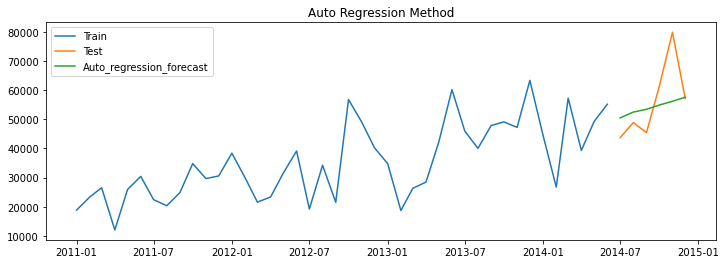

In [89]:
plt.figure(figsize = [12,4])

plt.plot(train, label = 'Train')
plt.plot(test,label = 'Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label = 'Auto_regression_forecast')

plt.title('Auto Regression Method')
plt.legend(loc = 'best')

- model is able to capture the trend but fails to cature the seasonality in the forecast

In [90]:
### Calculatting RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test.Sales,y_hat_ar.ar_forecast[test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test.Sales-y_hat_ar.ar_forecast[test.index.min():])/test.Sales)*100,2)

In [91]:
# adding the results along with mape and rmse values of the smoothing techniques
s= pd.DataFrame({'Method':['Autoregressive (AR) method'],'RMSE':[rmse],
                               'MAPE':[mape] })

results = pd.concat([smoothing_results,s])
results

,Method,RMSE,MAPE
0,Simple exponential smoothing,14627.34,15.74
0,Holt's exponential smoothing,18976.37,34.57
0,Holt Winters's additive forecast,9306.82,10.17
0,Holt Winters' multiplicative method,9423.23,11.43
0,Autoregressive (AR) method,10985.28,13.56


- simple AR model has lesser mape and rmse values than that of Holt's exponential smoothing techniques

#### 7.2 Moving average method (MA)

- The Moving Average Model models the future forecasts using past forecast errors in a regression-like model. This model has a parameter ‘q’ called window size over which linear combination of errors are calculated.
- here q =1


In [92]:
#building the model
model = ARIMA(train_data_boxcox_diff,order = (0,0,1))
model_fit = model.fit()
print(model_fit.params)

const      0.021415
ma.L1.y   -1.000000
dtype: float64


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [93]:
#### Recovering original time series
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),
                                                       data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

In [94]:
#### Plotting train, test and forecast

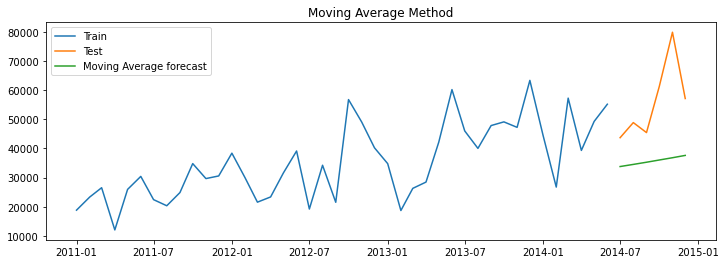

In [95]:
plt.figure(figsize = [12,4])

plt.plot(train, label = 'Train')
plt.plot(test,label = 'Test')
plt.plot(y_hat_ma.ma_forecast[test.index.min():], label = 'Moving Average forecast')

plt.title('Moving Average Method')
plt.legend(loc = 'best')

- model is able to capture the trend but fails to capture the seasonality in the forecast

In [96]:
### Calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test.Sales,y_hat_ma.ma_forecast[test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test.Sales-y_hat_ma.ma_forecast[test.index.min():])/test.Sales)*100,2)

In [97]:
# adding the rmse and mape values to results
s= pd.DataFrame({'Method': ['Moving Average (MA) method'],'RMSE': [rmse],
                               'MAPE':[mape] })

results = pd.concat([results,s])
results

,Method,RMSE,MAPE
0,Simple exponential smoothing,14627.34,15.74
0,Holt's exponential smoothing,18976.37,34.57
0,Holt Winters's additive forecast,9306.82,10.17
0,Holt Winters' multiplicative method,9423.23,11.43
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93


- Moving Average (MA) method forecasts better than Holt's exponential smoothing but worse than  	Autoregressive (AR) method

#### 7.3 Auto Regression Moving Average method(ARMA)

 - ARMA(p,q) model is used to forecast A time series that exhibits the characteristics of an AR(p) and/or an MA(q).

In [98]:
# building the model
model = ARIMA(train_data_boxcox_diff,order = (1,0,1))
model_fit = model.fit()
print(model_fit.params)

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const      0.02147
ar.L1.y    0.07458
ma.L1.y   -1.00000
dtype: float64


In [99]:
#### Recovering original time series
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),
                                                           data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox']  = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'] ) 

In [100]:
#### Plotting train, test and forecast

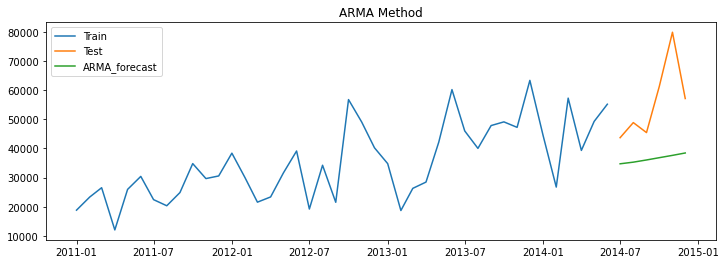

In [101]:
plt.figure(figsize = [12,4])

plt.plot(train, label = 'Train')
plt.plot(test,label = 'Test')
plt.plot(y_hat_arma.arma_forecast[test.index.min():], label = 'ARMA_forecast')

plt.title('ARMA Method')
plt.legend(loc = 'best')

- model is able to capture the trend but fails to cature the seasonality in the forecast

In [102]:
### Calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test.Sales,y_hat_arma.arma_forecast[test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test.Sales-y_hat_arma.arma_forecast[test.index.min():])/test.Sales)*100,2)

In [103]:
#adding rmse and mape to results
s= pd.DataFrame({'Method': ['Auto Regressive Moving Average (ARMA) method'],'RMSE': [rmse],
                               'MAPE':[mape] })

results = pd.concat([results,s])
results

,Method,RMSE,MAPE
0,Simple exponential smoothing,14627.34,15.74
0,Holt's exponential smoothing,18976.37,34.57
0,Holt Winters's additive forecast,9306.82,10.17
0,Holt Winters' multiplicative method,9423.23,11.43
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93
0,Auto Regressive Moving Average (ARMA) method,22654.32,32.40


-  Auto Regressive Moving Average (ARMA) method is forecasting better than Holt's exponential smoothing and Moving Average (MA) method but worse than Autoregressive (AR) method.

#### 7.4 Auto Regressive Integrated Moving Average (ARIMA) 

- models a series with the trend. It has an embedded parameter that difference the series to remove the trend and later integrate it into the original series.
- ARIMA model has three parameters
    p: Highest lag included in the regression model
    d: Degree of differencing to make the series stationary
    q: Number of past error terms included in the regression model
- here p=1,q=1,d=1

In [104]:
#building the model
model = ARIMA(train_data_boxcox,order=(1,1,1))
model_fit = model.fit()
print(model_fit.params)

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const        0.02147
ar.L1.D.y    0.07458
ma.L1.D.y   -1.00000
dtype: float64


In [105]:
#### Recovering original time series forecast
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),
                                                             data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

In [106]:
#### Plotting train, test and forecast

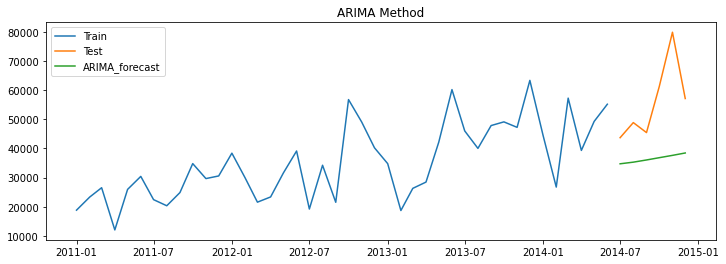

In [107]:
plt.figure(figsize = [12,4])

plt.plot(train, label = 'Train')
plt.plot(test,label = 'Test')
plt.plot(y_hat_arima.arima_forecast[test.index.min():], label = 'ARIMA_forecast')

plt.title('ARIMA Method')
plt.legend(loc = 'best')

- model is able to capture the trend but fails to cature the seasonality in the forecast

In [108]:
### Calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test.Sales,y_hat_arima.arima_forecast[test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test.Sales-y_hat_arima.arima_forecast[test.index.min():])/test.Sales)*100,2)

In [109]:
#adding rmse and mape to the results
s= pd.DataFrame({'Method': ['Auto Regressive Integrated Moving Average (ARIMA) method'],'RMSE': [rmse],
                               'MAPE':[mape] })

results = pd.concat([results,s])
results

,Method,RMSE,MAPE
0,Simple exponential smoothing,14627.34,15.74
0,Holt's exponential smoothing,18976.37,34.57
0,Holt Winters's additive forecast,9306.82,10.17
0,Holt Winters' multiplicative method,9423.23,11.43
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93
0,Auto Regressive Moving Average (ARMA) method,22654.32,32.40
0,Auto Regressive Integrated Moving Average (ARI...,22654.32,32.40


- ARIMA model has similar mape and rmse vales of  ARMA model

#### 7.5 Seasonal Auto Regressive Integrated Moving Average (SARIMA)

- SARIMA brings all the features of an ARIMA model with an extra feature - seasonality. 

- The seasonal elements of SARIMA

    Perform seasonal differencing on time series.
    Model future seasonality as linear regression of past observations of seasonality and past forecast errors of seasonality.


In [110]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [111]:
#building the model
model = SARIMAX(train_data_boxcox,order= (1,1,1),seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.params)

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ar.L1      -0.041875
ma.L1      -0.997313
ar.S.L12    0.099343
ma.S.L12   -0.973831
sigma2      0.058096
dtype: float64


In [112]:
#### Recovering the original time series forecast
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(),
                                                            data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast']= np.exp(y_hat_sarima['sarima_forecast_boxcox'])

In [113]:
#### Plotting train, test and forecast

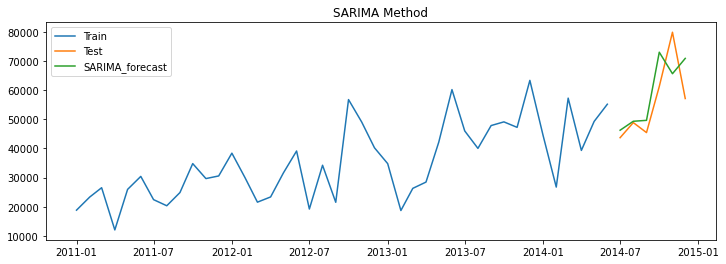

In [114]:
plt.figure(figsize = [12,4])

plt.plot(train, label = 'Train')
plt.plot(test,label = 'Test')
plt.plot(y_hat_sarima.sarima_forecast[test.index.min():], label = 'SARIMA_forecast')

plt.title('SARIMA Method')
plt.legend(loc = 'best')

- model is able to capture both trend and seasonality

In [115]:
### Calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test.Sales,y_hat_sarima.sarima_forecast[test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test.Sales-y_hat_sarima.sarima_forecast[test.index.min():])/test.Sales)*100,2)

In [116]:
# adding mape and rmse values to results
s= pd.DataFrame({'Method': ['Seasonal Auto Regressive Integrated Moving Average (SARIMA) method'],'RMSE': [rmse],
                               'MAPE':[mape] })

results = pd.concat([results,s])
results

,Method,RMSE,MAPE
0,Simple exponential smoothing,14627.34,15.74
0,Holt's exponential smoothing,18976.37,34.57
0,Holt Winters's additive forecast,9306.82,10.17
0,Holt Winters' multiplicative method,9423.23,11.43
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93
0,Auto Regressive Moving Average (ARMA) method,22654.32,32.40
0,Auto Regressive Integrated Moving Average (ARI...,22654.32,32.40
0,Seasonal Auto Regressive Integrated Moving Ave...,9614.23,12.86


# 8. Conclusions

-  'APAC_Consumer' is the most profitable market segment with least CoV value.
- Our initial time series data of monthly sales of 'APAC_Consumer'  had,
    - more than 10 historical data points
    - There was an upward trend
    - There was a seasonal component
- So from the flow chart of time series models, it was expected that `Holt Winters' smoothing method and SARIMA model` can better forecast  the monthly sales.

####  Holt Winters's additive forecast is the best smoothing technique for forecasting the sales of 'APAC_Consumer' .


#### SARIMA model is the best  autoregressive model for forecasting the monthly sales of 'APAC_Consumer'.